<a href="https://colab.research.google.com/github/HarisankarRNR/Dual_Track_Model-Image_Classification/blob/main/Swin_Transformer-Custom_CNN-triplet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install torchinfo
!pip install timm # kaggle doesnt have it installed by default
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import numpy as np
import pandas as pd
import os

import PIL
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torchvision
import torch.optim as optim
import timm
from  torchvision.ops.deform_conv import DeformConv2d
import torchinfo
import sys
from tqdm import tqdm
import time
import copy
import os

In [ ]:
transform = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.RandomRotation(45),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                ])
test_transform = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                    ])

device = "cuda" if torch.cuda.is_available() else "cpu"
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}

train_dataset_path = '/content/drive/MyDrive/CCPS_research/PlantVillage/grape_leaves_split_aug/train'
valid_dataset_path = '/content/drive/MyDrive/CCPS_research/PlantVillage/grape_leaves_split_aug/val'
test_dataset_path = '/content/drive/MyDrive/CCPS_research/PlantVillage/grape_leaves_split_aug/test'

train_dataset = datasets.ImageFolder(train_dataset_path, transform=transform)
valid_dataset = datasets.ImageFolder(valid_dataset_path, transform=transform)
test_dataset = datasets.ImageFolder(test_dataset_path,transform=test_transform)

train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, **kwargs)
valid_dataloader =  torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True, **kwargs)
test_dataloader =  torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, **kwargs)

CLASSES = train_dataset.classes
train_len = len(train_dataset)
valid_len = len(valid_dataset)
test_len = len(test_dataset)

In [ ]:
dataloaders = {
    "train": train_dataloader,
    "val": valid_dataloader
}
dataset_sizes = {
    "train": train_len,
    "val": valid_len
}

In [ ]:
import torch
import torch.nn as nn


class BasicConv(nn.Module):
    def __init__(
        self,
        in_planes,
        out_planes,
        kernel_size,
        stride=1,
        padding=0,
        dilation=1,
        groups=1,
        relu=True,
        bn=True,
        bias=False,
    ):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(
            in_planes,
            out_planes,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias,
        )
        self.bn = (
            nn.BatchNorm2d(out_planes, eps=1e-5, momentum=0.01, affine=True)
            if bn
            else None
        )
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x


class ZPool(nn.Module):
    def forward(self, x):
        return torch.cat(
            (torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1
        )


class AttentionGate(nn.Module):
    def __init__(self):
        super(AttentionGate, self).__init__()
        kernel_size = 7
        self.compress = ZPool()
        self.conv = BasicConv(
            2, 1, kernel_size, stride=1, padding=(kernel_size - 1) // 2, relu=False
        )

    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.conv(x_compress)
        scale = torch.sigmoid_(x_out)
        return x * scale


class TripletAttention(nn.Module):
    def __init__(self, no_spatial=False):
        super(TripletAttention, self).__init__()
        self.cw = AttentionGate()
        self.hc = AttentionGate()
        self.no_spatial = no_spatial
        if not no_spatial:
            self.hw = AttentionGate()

    def forward(self, x):
        x_perm1 = x.permute(0, 2, 1, 3).contiguous()
        x_out1 = self.cw(x_perm1)
        x_out11 = x_out1.permute(0, 2, 1, 3).contiguous()
        x_perm2 = x.permute(0, 3, 2, 1).contiguous()
        x_out2 = self.hc(x_perm2)
        x_out21 = x_out2.permute(0, 3, 2, 1).contiguous()
        if not self.no_spatial:
            x_out = self.hw(x)
            x_out = 1 / 3 * (x_out + x_out11 + x_out21)
        else:
            x_out = 1 / 2 * (x_out11 + x_out21)
        return x_out

In [ ]:
import torch
from torch import nn, einsum
import numpy as np
from einops import rearrange, repeat


class CyclicShift(nn.Module):
    def __init__(self, displacement):
        super().__init__()
        self.displacement = displacement

    def forward(self, x):
        return torch.roll(x, shifts=(self.displacement, self.displacement), dims=(1, 2))


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, x):
        return self.net(x)


def create_mask(window_size, displacement, upper_lower, left_right):
    mask = torch.zeros(window_size ** 2, window_size ** 2)

    if upper_lower:
        mask[-displacement * window_size:, :-displacement * window_size] = float('-inf')
        mask[:-displacement * window_size, -displacement * window_size:] = float('-inf')

    if left_right:
        mask = rearrange(mask, '(h1 w1) (h2 w2) -> h1 w1 h2 w2', h1=window_size, h2=window_size)
        mask[:, -displacement:, :, :-displacement] = float('-inf')
        mask[:, :-displacement, :, -displacement:] = float('-inf')
        mask = rearrange(mask, 'h1 w1 h2 w2 -> (h1 w1) (h2 w2)')

    return mask


def get_relative_distances(window_size):
    indices = torch.tensor(np.array([[x, y] for x in range(window_size) for y in range(window_size)]))
    distances = indices[None, :, :] - indices[:, None, :]
    return distances


class WindowAttention(nn.Module):
    def __init__(self, dim, heads, head_dim, shifted, window_size, relative_pos_embedding):
        super().__init__()
        inner_dim = head_dim * heads

        self.heads = heads
        self.scale = head_dim ** -0.5
        self.window_size = window_size
        self.relative_pos_embedding = relative_pos_embedding
        self.shifted = shifted

        if self.shifted:
            displacement = window_size // 2
            self.cyclic_shift = CyclicShift(-displacement)
            self.cyclic_back_shift = CyclicShift(displacement)
            self.upper_lower_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement,
                                                             upper_lower=True, left_right=False), requires_grad=False)
            self.left_right_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement,
                                                            upper_lower=False, left_right=True), requires_grad=False)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        if self.relative_pos_embedding:
            self.relative_indices = get_relative_distances(window_size) + window_size - 1
            self.pos_embedding = nn.Parameter(torch.randn(2 * window_size - 1, 2 * window_size - 1))
        else:
            self.pos_embedding = nn.Parameter(torch.randn(window_size ** 2, window_size ** 2))

        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x):
        if self.shifted:
            x = self.cyclic_shift(x)

        b, n_h, n_w, _, h = *x.shape, self.heads

        qkv = self.to_qkv(x).chunk(3, dim=-1)
        nw_h = n_h // self.window_size
        nw_w = n_w // self.window_size

        q, k, v = map(
            lambda t: rearrange(t, 'b (nw_h w_h) (nw_w w_w) (h d) -> b h (nw_h nw_w) (w_h w_w) d',
                                h=h, w_h=self.window_size, w_w=self.window_size), qkv)

        dots = einsum('b h w i d, b h w j d -> b h w i j', q, k) * self.scale

        if self.relative_pos_embedding:
            dots += self.pos_embedding[self.relative_indices[:, :, 0], self.relative_indices[:, :, 1]]
        else:
            dots += self.pos_embedding

        if self.shifted:
            dots[:, :, -nw_w:] += self.upper_lower_mask
            dots[:, :, nw_w - 1::nw_w] += self.left_right_mask

        attn = dots.softmax(dim=-1)

        out = einsum('b h w i j, b h w j d -> b h w i d', attn, v)
        out = rearrange(out, 'b h (nw_h nw_w) (w_h w_w) d -> b (nw_h w_h) (nw_w w_w) (h d)',
                        h=h, w_h=self.window_size, w_w=self.window_size, nw_h=nw_h, nw_w=nw_w)
        out = self.to_out(out)

        if self.shifted:
            out = self.cyclic_back_shift(out)
        return out


class SwinBlock(nn.Module):
    def __init__(self, dim, heads, head_dim, mlp_dim, shifted, window_size, relative_pos_embedding):
        super().__init__()
        self.attention_block = Residual(PreNorm(dim, WindowAttention(dim=dim,
                                                                     heads=heads,
                                                                     head_dim=head_dim,
                                                                     shifted=shifted,
                                                                     window_size=window_size,
                                                                     relative_pos_embedding=relative_pos_embedding)))
        self.mlp_block = Residual(PreNorm(dim, FeedForward(dim=dim, hidden_dim=mlp_dim)))

    def forward(self, x):
        x = self.attention_block(x)
        x = self.mlp_block(x)
        return x


class PatchMerging(nn.Module):
    def __init__(self, in_channels, out_channels, downscaling_factor):
        super().__init__()
        self.downscaling_factor = downscaling_factor
        self.patch_merge = nn.Unfold(kernel_size=downscaling_factor, stride=downscaling_factor, padding=0)
        self.linear = nn.Linear(in_channels * downscaling_factor ** 2, out_channels)

    def forward(self, x):
        b, c, h, w = x.shape
        new_h, new_w = h // self.downscaling_factor, w // self.downscaling_factor
        x = self.patch_merge(x).view(b, -1, new_h, new_w).permute(0, 2, 3, 1)
        x = self.linear(x)
        return x


class StageModule(nn.Module):
    def __init__(self, in_channels, hidden_dimension, layers, downscaling_factor, num_heads, head_dim, window_size,
                 relative_pos_embedding):
        super().__init__()
        assert layers % 2 == 0, 'Stage layers need to be divisible by 2 for regular and shifted block.'

        self.patch_partition = PatchMerging(in_channels=in_channels, out_channels=hidden_dimension,
                                            downscaling_factor=downscaling_factor)

        self.layers = nn.ModuleList([])
        for _ in range(layers // 2):
            self.layers.append(nn.ModuleList([
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=False, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=True, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
            ]))

    def forward(self, x):
        x = self.patch_partition(x)
        for regular_block, shifted_block in self.layers:
            x = regular_block(x)
            x = shifted_block(x)
        return x.permute(0, 3, 1, 2)


class SwinTransformer(nn.Module):
    def __init__(self, *, hidden_dim, layers, heads, channels=3, num_classes=1000, head_dim=32, window_size=7,
                 downscaling_factors=(4, 2, 2, 2), relative_pos_embedding=True):
        super().__init__()

        self.stage1 = StageModule(in_channels=channels, hidden_dimension=hidden_dim, layers=layers[0],
                                  downscaling_factor=downscaling_factors[0], num_heads=heads[0], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage2 = StageModule(in_channels=hidden_dim, hidden_dimension=hidden_dim * 2, layers=layers[1],
                                  downscaling_factor=downscaling_factors[1], num_heads=heads[1], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage3 = StageModule(in_channels=hidden_dim * 2, hidden_dimension=hidden_dim * 4, layers=layers[2],
                                  downscaling_factor=downscaling_factors[2], num_heads=heads[2], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage4 = StageModule(in_channels=hidden_dim * 4, hidden_dimension=hidden_dim * 8, layers=layers[3],
                                  downscaling_factor=downscaling_factors[3], num_heads=heads[3], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)

        # self.mlp_head = nn.Sequential(
        #     nn.LayerNorm(hidden_dim * 8),
        #     nn.Linear(hidden_dim * 8, num_classes)
        # )

    def forward(self, img):
        x = self.stage1(img)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        # x = x.mean(dim=[2, 3])
        return x


def swin_t(hidden_dim=96, layers=(2, 2, 6, 2), heads=(3, 6, 12, 24), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)


def swin_s(hidden_dim=96, layers=(2, 2, 18, 2), heads=(3, 6, 12, 24), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)


def swin_b(hidden_dim=128, layers=(2, 2, 18, 2), heads=(4, 8, 16, 32), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)


def swin_l(hidden_dim=192, layers=(2, 2, 18, 2), heads=(6, 12, 24, 48), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=3, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input,dim=1)
        # print("logpt is:",logpt)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)
        loss = -1 * (1-pt)**self.gamma * logpt
        # print("loss is :",loss)
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
class ChannelShuffle(nn.Module):
  def __init__(self,groups):
    super().__init__()
    self.groups = groups

  def forward(self,x):
    """
    Channel shuffle operation from 'ShuffleNet: An Extremely Efficient Convolutional Neural Network for Mobile Devices,'
    https://arxiv.org/abs/1707.01083.

    Parameters:
    ----------
    x : Tensor
        Input tensor.
    groups : int
        Number of groups.

    Returns
    -------
    Tensor
        Resulted tensor.
    """
    batch, channels, height, width = x.size()
    # assert (channels % groups == 0)
    channels_per_group = channels // self.groups
    x = x.view(batch, self.groups, channels_per_group, height, width)
    # print(x.shape)
    x = torch.transpose(x, 1, 2).contiguous()
    # print(x.shape)
    x = x.view(batch, channels, height, width)
    # print(x.shape)
    return x

In [ ]:
class GSDWR(nn.Module):
  def __init__(self,in_channels,out_channels):
    super().__init__()
    self.groupconv = nn.Conv2d(in_channels = in_channels,out_channels = out_channels,kernel_size = 1,stride=1,groups = 3)
    self.act1 = nn.ReLU()
    self.drop1 = nn.Dropout(0.3)
    self.shuffle = ChannelShuffle(2)

    self.depthwise = nn.Conv2d(in_channels=in_channels,out_channels = out_channels, kernel_size = 2,stride=2, groups = 2)
    self.pointwise = nn.Conv2d(in_channels=in_channels,out_channels = out_channels*2, kernel_size = 1)

  def forward(self,x):
    inpt = x
    x = self.act1(self.groupconv(x))
    x = self.drop1(x)
    x = self.shuffle(x)
    x = torch.add(x,inpt)
    x = self.depthwise(x)
    x = self.pointwise(x)
    return x

In [ ]:
class DeformableConvBlock(nn.Module):
  def __init__(self,in_channels,out_channels):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels = out_channels, kernel_size=1)
    self.act1 = nn.ReLU()
    self.deformconv = DeformConv2d(in_channels = in_channels, out_channels =out_channels, kernel_size=1,stride = 1)
    # self.deformconv = deform_conv2d(3,3,3,stride=2)
    self.act2 = nn.ReLU()
    self.depthwise = nn.Conv2d(in_channels=in_channels,out_channels = out_channels, kernel_size = 2, stride=2, groups = 2)
    self.pointwise = nn.Conv2d(in_channels=in_channels,out_channels = out_channels*2, kernel_size = 1)

  def forward(self,x):
    # print(x.shape)
    offset = x
    x = self.act1(self.conv1(x))
    x = self.act2(self.deformconv(x,offset))
    x = self.depthwise(x)
    x = self.pointwise(x)
    return x

In [ ]:
class LinearLayer(nn.Module):
  def __init__(self,input):
    super().__init__()
    # self.avgpool = torch.mean()
    self.linear1 = nn.Linear(input, 512)
    self.act1 = nn.ReLU()
    self.drop = nn.Dropout(0.3)
    self.linear2 = nn.Linear(512, 4)

  def forward(self,x):
    # print(x.shape())
    x = torch.mean(x,dim=[2,3])
    # x = self.flat(x)
    x = self.act1(self.linear1(x))
    x = self.drop(x)
    x = self.linear2(x)
    return x

In [ ]:
class swin_model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6,kernel_size = 2,stride=2)
    self.swin_out = SwinTransformer(hidden_dim = 12,
                      layers = (2,2,6,2),
                      heads = (3,6,12,24),
                      channels = 6,
                      num_classes = 23,
                      downscaling_factors=(2, 2, 2, 2)
                      )
  def forward(self,x):
    x = self.conv1(x)
    x = self.swin_out(x)
    return x

In [ ]:
class CNN_model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6,kernel_size = 2,stride=2)
    self.gsdwr1 = GSDWR(6,6)
    self.batchnorm1 = nn.BatchNorm2d(12)
    self.deform1 = DeformableConvBlock(12,12)
    self.batchnorm2 = nn.BatchNorm2d(24)
    self.gsdwr2 = GSDWR(24,24)
    self.batchnorm3 = nn.BatchNorm2d(48)
    self.deform2 = DeformableConvBlock(48,48)

  def forward(self,x):
    x = self.conv1(x)
    x = self.gsdwr1(x)
    x = self.batchnorm1(x)
    x = self.deform1(x)
    x = self.batchnorm2(x)
    x = self.gsdwr2(x)
    x = self.batchnorm3(x)
    x = self.deform2(x)
    return x


In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.swin_out = swin_model()
    self.cnn_out = CNN_model()
    self.triplet = TripletAttention()
    self.linear = LinearLayer(192)

  def forward(self,x):
    x1 = self.swin_out(x)
    x2 = self.cnn_out(x)
    x = torch.cat([x1,x2], dim=1)
    x = self.triplet(x)
    x = self.linear(x)
    return x

In [ ]:
model = Model()
torchinfo.summary(model, (32,3, 224, 224))

Layer (type:depth-idx)                                                 Output Shape              Param #
Model                                                                  [32, 4]                   --
├─swin_model: 1-1                                                      [32, 96, 7, 7]            --
│    └─Conv2d: 2-1                                                     [32, 6, 112, 112]         78
│    └─SwinTransformer: 2-2                                            [32, 96, 7, 7]            --
│    │    └─StageModule: 3-1                                           [32, 12, 56, 56]          17,200
│    │    └─StageModule: 3-2                                           [32, 24, 28, 28]          52,876
│    │    └─StageModule: 3-3                                           [32, 48, 14, 14]          575,916
│    │    └─StageModule: 3-4                                           [32, 96, 7, 7]            762,868
├─CNN_model: 1-2                                                       [32, 9

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0002)
# criterion = FocalLoss(alpha =class_weights,gamma=2)
criterion = criterion.to(device)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.97)
os.chdir("/content/drive/MyDrive/CCPS_research/logs_grapes")

In [ ]:
# checkpoint = torch.load(f"swin_cnn_triplet/model40.pt")
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
# print(loss)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, path, train_log, valid_log, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    df_train = pd.DataFrame(columns = ['epoch', 'train_loss', 'train_acc'])
    df_val = pd.DataFrame(columns = ['epoch','val_loss','val_acc'])
    for epoch in range(1,num_epochs+1):
        print(f'Epoch {epoch}/{num_epochs}')
        print("-"*10)


        if not os.path.isdir(path):
          os.mkdir(path)
        # else:
        #   checkpoint = torch.load(f"checkpoints/model{epoch-1}.pt")
        #   model.load_state_dict(checkpoint['model_state_dict'])
        #   optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
          # epoch = checkpoint['epoch']
          # loss = checkpoint['loss']

        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    outputs = model(inputs)
                    # print("outputs are: ",outputs)
                    _, preds = torch.max(outputs, 1) # used for accuracy
                    # print("\nEntering loss")
                    loss = criterion(outputs, labels)
                    # print("loss obtained: ",loss)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                scheduler.step() # step at end of epoch
            # print(type(epoch))
            # print(type(epoch_loss))
            # print(type(epoch_acc))
            if phase=='train':
              # print("Done")
              df_new_row = pd.DataFrame({ 'epoch': [epoch], 'train_loss': [epoch_loss],'train_acc':[epoch_acc.cpu()] })
              # print("done2")
              df_train = pd.concat([df_train, df_new_row])
              df_train.to_csv(f'{path}/{train_log}.csv')
            elif phase=='val':
              df_new_row = pd.DataFrame({ 'epoch': [epoch], 'val_loss': [epoch_loss],'val_acc':[epoch_acc.cpu()] })
              df_val = pd.concat([df_val, df_new_row])
              df_val.to_csv(f'{path}/{valid_log}.csv')
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            ## save torch model for checkpoints

            if epoch_acc > best_acc:
              torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': epoch_loss,
              }, f"{path}/model{epoch}.pt")

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
        print()

    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, "swin_cnn_triplet_best","train_cnn","val_cnn",num_epochs=100)

Epoch 1/100
----------


100%|██████████| 87/87 [07:07<00:00,  4.91s/it]


train Loss: 1.0815 Acc: 0.4806


100%|██████████| 29/29 [03:05<00:00,  6.39s/it]


val Loss: 1.4069 Acc: 0.5102

Epoch 2/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.09it/s]


train Loss: 0.6946 Acc: 0.7128


100%|██████████| 29/29 [00:04<00:00,  6.03it/s]


val Loss: 0.6060 Acc: 0.7540

Epoch 3/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.16it/s]


train Loss: 0.6242 Acc: 0.7336


100%|██████████| 29/29 [00:04<00:00,  6.93it/s]


val Loss: 0.5975 Acc: 0.7778

Epoch 4/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.14it/s]


train Loss: 0.5902 Acc: 0.7725


100%|██████████| 29/29 [00:04<00:00,  6.12it/s]


val Loss: 0.5372 Acc: 0.7756

Epoch 5/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.28it/s]


train Loss: 0.5415 Acc: 0.7840


100%|██████████| 29/29 [00:05<00:00,  5.39it/s]


val Loss: 0.4711 Acc: 0.8188

Epoch 6/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.19it/s]


train Loss: 0.4949 Acc: 0.8023


100%|██████████| 29/29 [00:04<00:00,  6.99it/s]


val Loss: 0.6204 Acc: 0.7271

Epoch 7/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.12it/s]


train Loss: 0.4742 Acc: 0.8124


100%|██████████| 29/29 [00:04<00:00,  6.84it/s]


val Loss: 0.4631 Acc: 0.8328

Epoch 8/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.23it/s]


train Loss: 0.4670 Acc: 0.8253


100%|██████████| 29/29 [00:05<00:00,  4.92it/s]


val Loss: 0.3864 Acc: 0.8468

Epoch 9/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.13it/s]


train Loss: 0.3667 Acc: 0.8505


100%|██████████| 29/29 [00:04<00:00,  7.00it/s]


val Loss: 0.5084 Acc: 0.7918

Epoch 10/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.08it/s]


train Loss: 0.3929 Acc: 0.8429


100%|██████████| 29/29 [00:04<00:00,  7.01it/s]


val Loss: 0.7687 Acc: 0.7098

Epoch 11/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.09it/s]


train Loss: 0.3050 Acc: 0.8742


100%|██████████| 29/29 [00:06<00:00,  4.62it/s]


val Loss: 0.4064 Acc: 0.8501

Epoch 12/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.16it/s]


train Loss: 0.2953 Acc: 0.8911


100%|██████████| 29/29 [00:04<00:00,  7.05it/s]


val Loss: 0.4157 Acc: 0.8393

Epoch 13/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.15it/s]


train Loss: 0.2782 Acc: 0.8893


100%|██████████| 29/29 [00:04<00:00,  7.04it/s]


val Loss: 0.7875 Acc: 0.7368

Epoch 14/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.09it/s]


train Loss: 0.2359 Acc: 0.9076


100%|██████████| 29/29 [00:05<00:00,  5.21it/s]


val Loss: 0.2823 Acc: 0.8997

Epoch 15/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.17it/s]


train Loss: 0.2399 Acc: 0.9159


100%|██████████| 29/29 [00:04<00:00,  6.52it/s]


val Loss: 0.2484 Acc: 0.9072

Epoch 16/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.18it/s]


train Loss: 0.2200 Acc: 0.9141


100%|██████████| 29/29 [00:04<00:00,  7.16it/s]


val Loss: 0.3568 Acc: 0.8857

Epoch 17/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.18it/s]


train Loss: 0.2176 Acc: 0.9180


100%|██████████| 29/29 [00:05<00:00,  5.33it/s]


val Loss: 0.2197 Acc: 0.9169

Epoch 18/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.13it/s]


train Loss: 0.1735 Acc: 0.9331


100%|██████████| 29/29 [00:04<00:00,  6.38it/s]


val Loss: 0.2924 Acc: 0.8943

Epoch 19/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.12it/s]


train Loss: 0.1887 Acc: 0.9303


100%|██████████| 29/29 [00:04<00:00,  7.18it/s]


val Loss: 0.5683 Acc: 0.7940

Epoch 20/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.17it/s]


train Loss: 0.1694 Acc: 0.9328


100%|██████████| 29/29 [00:05<00:00,  5.53it/s]


val Loss: 0.5596 Acc: 0.8576

Epoch 21/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.01it/s]


train Loss: 0.1416 Acc: 0.9508


100%|██████████| 29/29 [00:04<00:00,  6.25it/s]


val Loss: 0.2271 Acc: 0.9137

Epoch 22/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.21it/s]


train Loss: 0.1253 Acc: 0.9597


100%|██████████| 29/29 [00:04<00:00,  7.08it/s]


val Loss: 0.1919 Acc: 0.9331

Epoch 23/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.15it/s]


train Loss: 0.1748 Acc: 0.9339


100%|██████████| 29/29 [00:04<00:00,  5.82it/s]


val Loss: 0.1918 Acc: 0.9385

Epoch 24/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.14it/s]


train Loss: 0.1525 Acc: 0.9432


100%|██████████| 29/29 [00:04<00:00,  6.15it/s]


val Loss: 0.2775 Acc: 0.9159

Epoch 25/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.15it/s]


train Loss: 0.1444 Acc: 0.9464


100%|██████████| 29/29 [00:04<00:00,  6.78it/s]


val Loss: 0.1551 Acc: 0.9515

Epoch 26/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.08it/s]


train Loss: 0.0961 Acc: 0.9626


100%|██████████| 29/29 [00:05<00:00,  5.65it/s]


val Loss: 0.1587 Acc: 0.9536

Epoch 27/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.23it/s]


train Loss: 0.1194 Acc: 0.9605


100%|██████████| 29/29 [00:04<00:00,  5.98it/s]


val Loss: 0.1255 Acc: 0.9558

Epoch 28/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.18it/s]


train Loss: 0.1100 Acc: 0.9633


100%|██████████| 29/29 [00:03<00:00,  7.26it/s]


val Loss: 0.1357 Acc: 0.9536

Epoch 29/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.15it/s]


train Loss: 0.0759 Acc: 0.9752


100%|██████████| 29/29 [00:04<00:00,  5.91it/s]


val Loss: 0.1231 Acc: 0.9569

Epoch 30/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.20it/s]


train Loss: 0.0967 Acc: 0.9641


100%|██████████| 29/29 [00:04<00:00,  5.90it/s]


val Loss: 0.1916 Acc: 0.9504

Epoch 31/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.11it/s]


train Loss: 0.0921 Acc: 0.9662


100%|██████████| 29/29 [00:04<00:00,  6.97it/s]


val Loss: 1.0833 Acc: 0.7120

Epoch 32/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.15it/s]


train Loss: 0.0944 Acc: 0.9684


100%|██████████| 29/29 [00:04<00:00,  6.22it/s]


val Loss: 0.1405 Acc: 0.9515

Epoch 33/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.25it/s]


train Loss: 0.0682 Acc: 0.9752


100%|██████████| 29/29 [00:05<00:00,  5.29it/s]


val Loss: 0.1022 Acc: 0.9698

Epoch 34/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.17it/s]


train Loss: 0.0761 Acc: 0.9723


100%|██████████| 29/29 [00:04<00:00,  6.93it/s]


val Loss: 0.1059 Acc: 0.9676

Epoch 35/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.17it/s]


train Loss: 0.0678 Acc: 0.9745


100%|██████████| 29/29 [00:04<00:00,  6.46it/s]


val Loss: 0.0735 Acc: 0.9730

Epoch 36/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.15it/s]


train Loss: 0.0692 Acc: 0.9741


100%|██████████| 29/29 [00:05<00:00,  5.33it/s]


val Loss: 0.1284 Acc: 0.9622

Epoch 37/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.16it/s]


train Loss: 0.0714 Acc: 0.9734


100%|██████████| 29/29 [00:04<00:00,  6.84it/s]


val Loss: 0.2585 Acc: 0.9245

Epoch 38/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.09it/s]


train Loss: 0.0809 Acc: 0.9705


100%|██████████| 29/29 [00:04<00:00,  6.55it/s]


val Loss: 0.1271 Acc: 0.9590

Epoch 39/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.17it/s]


train Loss: 0.0610 Acc: 0.9781


100%|██████████| 29/29 [00:05<00:00,  5.04it/s]


val Loss: 0.1085 Acc: 0.9601

Epoch 40/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.09it/s]


train Loss: 0.0627 Acc: 0.9766


100%|██████████| 29/29 [00:04<00:00,  6.95it/s]


val Loss: 0.0796 Acc: 0.9687

Epoch 41/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.15it/s]


train Loss: 0.0569 Acc: 0.9806


100%|██████████| 29/29 [00:04<00:00,  6.94it/s]


val Loss: 0.0899 Acc: 0.9698

Epoch 42/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.15it/s]


train Loss: 0.0616 Acc: 0.9752


100%|██████████| 29/29 [00:05<00:00,  4.94it/s]


val Loss: 0.5545 Acc: 0.8328

Epoch 43/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.15it/s]


train Loss: 0.0682 Acc: 0.9784


100%|██████████| 29/29 [00:04<00:00,  6.91it/s]


val Loss: 0.0994 Acc: 0.9720

Epoch 44/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.08it/s]


train Loss: 0.0523 Acc: 0.9835


100%|██████████| 29/29 [00:04<00:00,  6.94it/s]


val Loss: 0.0955 Acc: 0.9676

Epoch 45/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.10it/s]


train Loss: 0.0441 Acc: 0.9842


100%|██████████| 29/29 [00:05<00:00,  4.85it/s]


val Loss: 0.1012 Acc: 0.9698

Epoch 46/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.15it/s]


train Loss: 0.0545 Acc: 0.9806


100%|██████████| 29/29 [00:04<00:00,  6.76it/s]


val Loss: 0.4279 Acc: 0.8252

Epoch 47/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.11it/s]


train Loss: 0.0837 Acc: 0.9705


100%|██████████| 29/29 [00:04<00:00,  7.08it/s]


val Loss: 0.1438 Acc: 0.9579

Epoch 48/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.14it/s]


train Loss: 0.0555 Acc: 0.9827


100%|██████████| 29/29 [00:06<00:00,  4.68it/s]


val Loss: 0.0946 Acc: 0.9709

Epoch 49/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.14it/s]


train Loss: 0.0323 Acc: 0.9896


100%|██████████| 29/29 [00:04<00:00,  7.17it/s]


val Loss: 0.1081 Acc: 0.9720

Epoch 50/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.08it/s]


train Loss: 0.0358 Acc: 0.9881


100%|██████████| 29/29 [00:04<00:00,  7.15it/s]


val Loss: 0.4718 Acc: 0.8457

Epoch 51/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.14it/s]


train Loss: 0.0437 Acc: 0.9838


100%|██████████| 29/29 [00:05<00:00,  4.93it/s]


val Loss: 0.2751 Acc: 0.9126

Epoch 52/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.17it/s]


train Loss: 0.0701 Acc: 0.9759


100%|██████████| 29/29 [00:04<00:00,  7.02it/s]


val Loss: 0.1012 Acc: 0.9687

Epoch 53/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.18it/s]


train Loss: 0.0422 Acc: 0.9863


100%|██████████| 29/29 [00:04<00:00,  7.06it/s]


val Loss: 0.0841 Acc: 0.9752

Epoch 54/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.14it/s]


train Loss: 0.0442 Acc: 0.9845


100%|██████████| 29/29 [00:05<00:00,  5.03it/s]


val Loss: 0.1714 Acc: 0.9428

Epoch 55/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.17it/s]


train Loss: 0.0429 Acc: 0.9871


100%|██████████| 29/29 [00:04<00:00,  6.79it/s]


val Loss: 0.0802 Acc: 0.9773

Epoch 56/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.14it/s]


train Loss: 0.0460 Acc: 0.9835


100%|██████████| 29/29 [00:04<00:00,  7.08it/s]


val Loss: 0.0793 Acc: 0.9730

Epoch 57/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.15it/s]


train Loss: 0.0257 Acc: 0.9910


100%|██████████| 29/29 [00:05<00:00,  5.21it/s]


val Loss: 0.0834 Acc: 0.9741

Epoch 58/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.12it/s]


train Loss: 0.0498 Acc: 0.9824


100%|██████████| 29/29 [00:04<00:00,  6.47it/s]


val Loss: 0.1223 Acc: 0.9601

Epoch 59/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.20it/s]


train Loss: 0.0341 Acc: 0.9885


100%|██████████| 29/29 [00:04<00:00,  7.02it/s]


val Loss: 0.1117 Acc: 0.9644

Epoch 60/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.08it/s]


train Loss: 0.0327 Acc: 0.9874


100%|██████████| 29/29 [00:04<00:00,  5.95it/s]


val Loss: 0.0647 Acc: 0.9806

Epoch 61/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.13it/s]


train Loss: 0.0346 Acc: 0.9874


100%|██████████| 29/29 [00:04<00:00,  6.03it/s]


val Loss: 0.2354 Acc: 0.9245

Epoch 62/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.16it/s]


train Loss: 0.0287 Acc: 0.9899


100%|██████████| 29/29 [00:04<00:00,  6.97it/s]


val Loss: 0.1819 Acc: 0.9428

Epoch 63/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.18it/s]


train Loss: 0.0610 Acc: 0.9738


100%|██████████| 29/29 [00:04<00:00,  6.12it/s]


val Loss: 0.1187 Acc: 0.9655

Epoch 64/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.20it/s]


train Loss: 0.0441 Acc: 0.9853


100%|██████████| 29/29 [00:05<00:00,  5.41it/s]


val Loss: 0.1810 Acc: 0.9374

Epoch 65/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.19it/s]


train Loss: 0.0384 Acc: 0.9856


100%|██████████| 29/29 [00:04<00:00,  7.03it/s]


val Loss: 0.1474 Acc: 0.9601

Epoch 66/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.14it/s]


train Loss: 0.0267 Acc: 0.9914


100%|██████████| 29/29 [00:04<00:00,  7.13it/s]


val Loss: 1.1139 Acc: 0.7174

Epoch 67/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.16it/s]


train Loss: 0.0654 Acc: 0.9781


100%|██████████| 29/29 [00:06<00:00,  4.83it/s]


val Loss: 0.1314 Acc: 0.9547

Epoch 68/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.12it/s]


train Loss: 0.0258 Acc: 0.9928


100%|██████████| 29/29 [00:04<00:00,  7.04it/s]


val Loss: 0.1010 Acc: 0.9687

Epoch 69/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.14it/s]


train Loss: 0.0216 Acc: 0.9928


100%|██████████| 29/29 [00:04<00:00,  6.92it/s]


val Loss: 0.1158 Acc: 0.9709

Epoch 70/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.12it/s]


train Loss: 0.0409 Acc: 0.9856


100%|██████████| 29/29 [00:06<00:00,  4.74it/s]


val Loss: 0.0953 Acc: 0.9730

Epoch 71/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.16it/s]


train Loss: 0.0325 Acc: 0.9885


100%|██████████| 29/29 [00:04<00:00,  6.95it/s]


val Loss: 0.1664 Acc: 0.9579

Epoch 72/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.09it/s]


train Loss: 0.0586 Acc: 0.9792


100%|██████████| 29/29 [00:04<00:00,  6.99it/s]


val Loss: 0.0773 Acc: 0.9763

Epoch 73/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.11it/s]


train Loss: 0.0209 Acc: 0.9953


100%|██████████| 29/29 [00:05<00:00,  5.25it/s]


val Loss: 0.1287 Acc: 0.9687

Epoch 74/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.18it/s]


train Loss: 0.0551 Acc: 0.9795


100%|██████████| 29/29 [00:04<00:00,  6.16it/s]


val Loss: 0.1475 Acc: 0.9547

Epoch 75/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.17it/s]


train Loss: 0.0300 Acc: 0.9899


100%|██████████| 29/29 [00:04<00:00,  6.98it/s]


val Loss: 0.1181 Acc: 0.9633

Epoch 76/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.10it/s]


train Loss: 0.0252 Acc: 0.9914


100%|██████████| 29/29 [00:05<00:00,  5.57it/s]


val Loss: 0.1540 Acc: 0.9558

Epoch 77/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.19it/s]


train Loss: 0.0197 Acc: 0.9932


100%|██████████| 29/29 [00:04<00:00,  6.00it/s]


val Loss: 0.0932 Acc: 0.9763

Epoch 78/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.13it/s]


train Loss: 0.0278 Acc: 0.9921


100%|██████████| 29/29 [00:04<00:00,  7.05it/s]


val Loss: 0.1365 Acc: 0.9622

Epoch 79/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.15it/s]


train Loss: 0.0305 Acc: 0.9892


100%|██████████| 29/29 [00:04<00:00,  5.89it/s]


val Loss: 0.0747 Acc: 0.9806

Epoch 80/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.12it/s]


train Loss: 0.0159 Acc: 0.9957


100%|██████████| 29/29 [00:05<00:00,  5.39it/s]


val Loss: 0.1613 Acc: 0.9622

Epoch 81/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.14it/s]


train Loss: 0.0550 Acc: 0.9820


100%|██████████| 29/29 [00:04<00:00,  6.94it/s]


val Loss: 0.0766 Acc: 0.9817

Epoch 82/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.12it/s]


train Loss: 0.0361 Acc: 0.9896


100%|██████████| 29/29 [00:04<00:00,  6.23it/s]


val Loss: 0.0858 Acc: 0.9709

Epoch 83/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.13it/s]


train Loss: 0.0138 Acc: 0.9971


100%|██████████| 29/29 [00:05<00:00,  5.33it/s]


val Loss: 0.0869 Acc: 0.9773

Epoch 84/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.14it/s]


train Loss: 0.0129 Acc: 0.9950


100%|██████████| 29/29 [00:04<00:00,  7.02it/s]


val Loss: 0.0840 Acc: 0.9806

Epoch 85/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.11it/s]


train Loss: 0.0313 Acc: 0.9881


100%|██████████| 29/29 [00:04<00:00,  6.34it/s]


val Loss: 0.1355 Acc: 0.9633

Epoch 86/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.10it/s]


train Loss: 0.0469 Acc: 0.9820


100%|██████████| 29/29 [00:05<00:00,  5.15it/s]


val Loss: 0.2307 Acc: 0.9234

Epoch 87/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.11it/s]


train Loss: 0.0296 Acc: 0.9907


100%|██████████| 29/29 [00:04<00:00,  6.93it/s]


val Loss: 0.1104 Acc: 0.9752

Epoch 88/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.01it/s]


train Loss: 0.0210 Acc: 0.9932


100%|██████████| 29/29 [00:04<00:00,  6.10it/s]


val Loss: 0.0725 Acc: 0.9817

Epoch 89/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.07it/s]


train Loss: 0.0209 Acc: 0.9942


100%|██████████| 29/29 [00:05<00:00,  5.61it/s]


val Loss: 0.0893 Acc: 0.9752

Epoch 90/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.07it/s]


train Loss: 0.0089 Acc: 0.9960


100%|██████████| 29/29 [00:04<00:00,  6.90it/s]


val Loss: 0.1239 Acc: 0.9720

Epoch 91/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.10it/s]


train Loss: 0.0157 Acc: 0.9950


100%|██████████| 29/29 [00:04<00:00,  6.15it/s]


val Loss: 0.0833 Acc: 0.9827

Epoch 92/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.14it/s]


train Loss: 0.0130 Acc: 0.9960


100%|██████████| 29/29 [00:05<00:00,  5.43it/s]


val Loss: 0.1144 Acc: 0.9741

Epoch 93/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.07it/s]


train Loss: 0.0437 Acc: 0.9863


100%|██████████| 29/29 [00:04<00:00,  6.94it/s]


val Loss: 0.0758 Acc: 0.9741

Epoch 94/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.06it/s]


train Loss: 0.0165 Acc: 0.9942


100%|██████████| 29/29 [00:04<00:00,  6.03it/s]


val Loss: 0.1359 Acc: 0.9601

Epoch 95/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.12it/s]


train Loss: 0.0148 Acc: 0.9953


100%|██████████| 29/29 [00:05<00:00,  5.50it/s]


val Loss: 0.2049 Acc: 0.9504

Epoch 96/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.02it/s]


train Loss: 0.0496 Acc: 0.9827


100%|██████████| 29/29 [00:04<00:00,  6.96it/s]


val Loss: 0.0823 Acc: 0.9741

Epoch 97/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.09it/s]


train Loss: 0.0174 Acc: 0.9942


100%|██████████| 29/29 [00:04<00:00,  6.06it/s]


val Loss: 0.0932 Acc: 0.9773

Epoch 98/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.13it/s]


train Loss: 0.0203 Acc: 0.9928


100%|██████████| 29/29 [00:05<00:00,  5.49it/s]


val Loss: 0.0947 Acc: 0.9763

Epoch 99/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.15it/s]


train Loss: 0.0389 Acc: 0.9892


100%|██████████| 29/29 [00:04<00:00,  7.02it/s]


val Loss: 0.1232 Acc: 0.9687

Epoch 100/100
----------


100%|██████████| 87/87 [00:17<00:00,  5.07it/s]


train Loss: 0.0067 Acc: 0.9989


100%|██████████| 29/29 [00:04<00:00,  6.30it/s]

val Loss: 0.0770 Acc: 0.9795

Training complete in 46m 21s
Best Val Acc: 0.9827


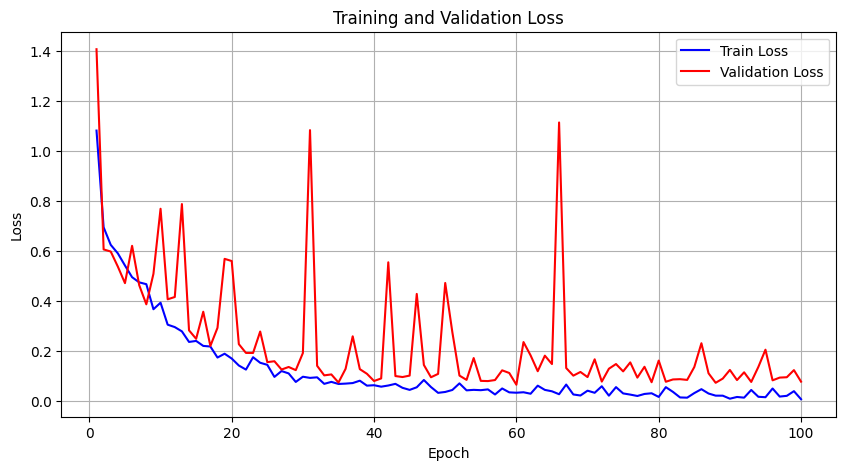

In [ ]:
import matplotlib.pyplot as plt
train_loss_df = pd.read_csv("swin_cnn_triplet_best/train_cnn.csv")
val_loss_df = pd.read_csv("swin_cnn_triplet_best/val_cnn.csv")

plt.figure(figsize=(10, 5))
plt.plot(train_loss_df['epoch'], train_loss_df['train_loss'], label='Train Loss', color='blue')
plt.plot(val_loss_df['epoch'], val_loss_df['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

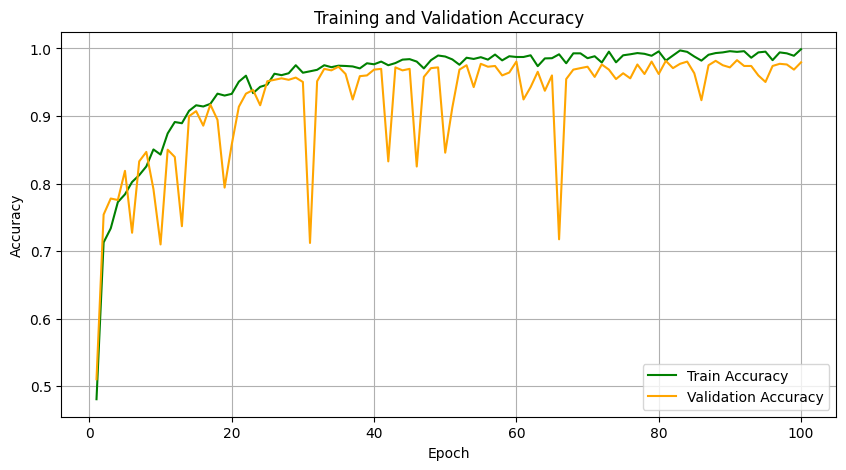

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
def extract_numeric_value(x):
    match = re.search(r'\d+\.\d+', x)
    if match:
        return float(match.group())
    else:
        return None

val_acc_values = val_loss_df['val_acc'].apply(extract_numeric_value)
train_acc_values = train_loss_df['train_acc'].apply(extract_numeric_value)

plt.figure(figsize=(10, 5))
plt.plot(train_loss_df['epoch'], train_acc_values, label='Train Accuracy', color='green')
plt.plot(val_loss_df['epoch'], val_acc_values, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
checkpoint = torch.load(f"swin_cnn_triplet_best/model79.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
print(loss)

0.030532683451845104


In [ ]:
predictions = []
label = []
for inputs, labels in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()

    with torch.set_grad_enabled(True): # no autograd makes validation go faster
        outputs = model(inputs)
        # print("outputs are: ",outputs)
        _, preds = torch.max(outputs, 1) # used for accuracy
        for i in preds:
          predictions.append(i)
        for i in labels:
          label.append(i)

  0%|          | 0/30 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 30/30 [00:06<00:00,  4.62it/s]


In [ ]:
predictions_cpu = [int(i.cpu().numpy()) for i in predictions]
label_cpu = [int(i.cpu().numpy()) for i in label]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(label_cpu, predictions_cpu,target_names=CLASSES, zero_division = 0,digits=4))

                                            precision    recall  f1-score   support

                         Grape___Black_rot     0.9703    0.9703    0.9703       236
              Grape___Esca_(Black_Measles)     0.9822    0.9928    0.9875       278
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)     0.9953    0.9815    0.9883       216
                           Grape___healthy     0.9900    0.9900    0.9900       200

                                  accuracy                         0.9839       930
                                 macro avg     0.9845    0.9837    0.9840       930
                              weighted avg     0.9839    0.9839    0.9839       930



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(label_cpu, predictions_cpu,target_names=CLASSES, zero_division = 0,digits=4))

                                            precision    recall  f1-score   support

                         Grape___Black_rot     0.9703    0.9703    0.9703       236
              Grape___Esca_(Black_Measles)     0.9822    0.9928    0.9875       278
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)     0.9953    0.9815    0.9883       216
                           Grape___healthy     0.9900    0.9900    0.9900       200

                                  accuracy                         0.9839       930
                                 macro avg     0.9845    0.9837    0.9840       930
                              weighted avg     0.9839    0.9839    0.9839       930



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(label_cpu,predictions_cpu)
cm_int = cm.astype(int)

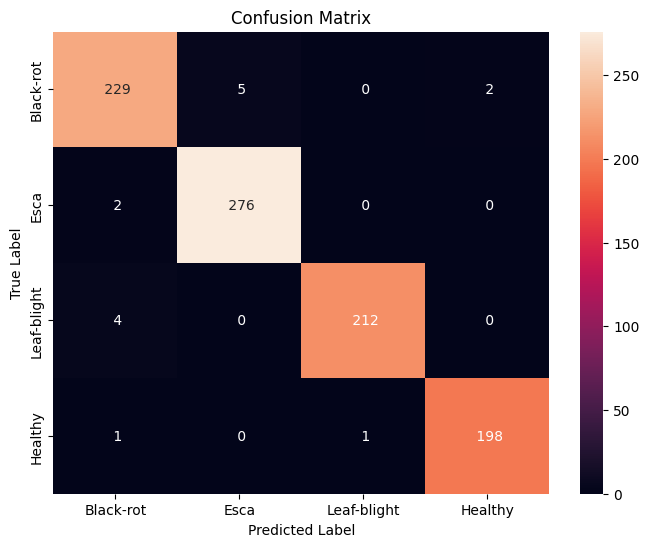

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cf_matrix = confusion_matrix(label_cpu, predictions_cpu)

labels = ['Black-rot','Esca','Leaf-blight','Healthy']
# cm_str = np.asarray(cf_matrix, dtype=str)
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix, annot = True, fmt = ' ',xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.savefig('/content/confusion_matrix_final.pdf', bbox_inches='tight')
plt.savefig('/content/confusion_matrix_final.png', bbox_inches='tight')

plt.show()

In [ ]:
y_test = np.array(label_cpu)
y_score = np.array(predictions_cpu)
n_classes = 4

0.9870188326578185


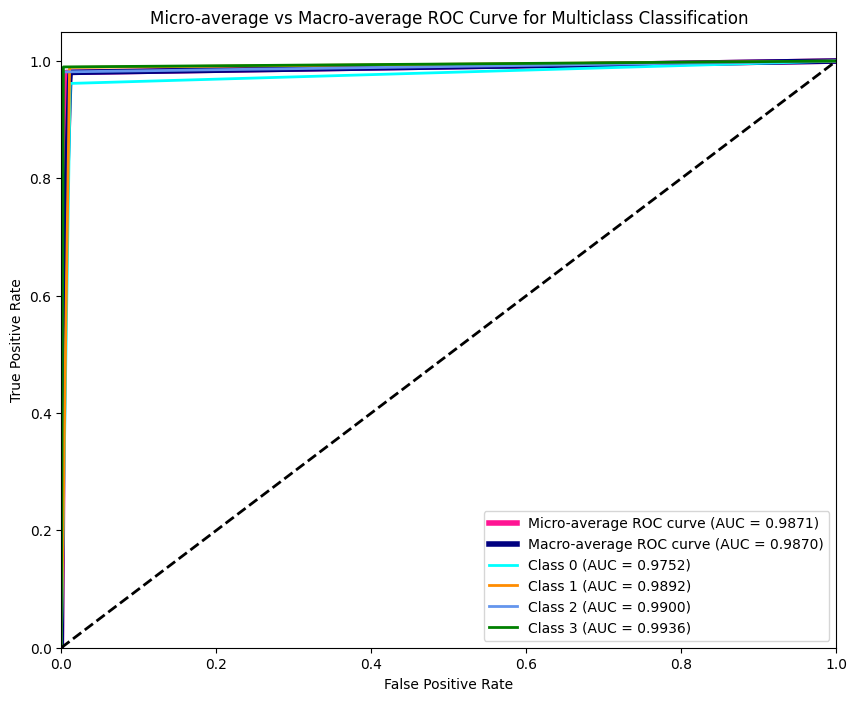

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from itertools import cycle

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
y_score = label_binarize(y_score, classes=[0, 1, 2, 3])
auc_score = roc_auc_score(y_test_bin, y_score, multi_class="ovr")
print(auc_score)

fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve and ROC AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:0.4f})',
         color='deeppink', linestyle='-', linewidth=4)

# Plot macro-average ROC curve
plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:0.4f})',
         color='navy', linestyle='-', linewidth=4)

# Plot ROC curves for each class
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:0.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average vs Macro-average ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()
